Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] Image(str, width=200)
    [2] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
                [1] Button(button_type='primary', name='Speak to microphone')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=300, loading_indicator=True)
            [3] Divider()
            [4] Row
                [0] Button(button_type='primary', name='Convert to Speech')
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.pdf')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
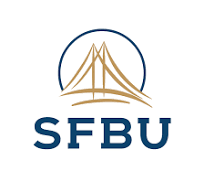

In [10]:
# Import necessary libraries
import panel as pn
import param
from pydub import AudioSegment
from pydub.playback import play
import openai
import queue
import threading
from pathlib import Path

import sys
sys.path.append('../..')

import panel as pn  # GUI
pn.extension()

import speech_recognition as sr
import whisper
import queue
import os
import threading
import torch
import numpy as np
import re
from gtts import gTTS
import openai
import click
import sys

from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain.chains import RetrievalQA, ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import PyPDFLoader

from openai import OpenAI
client = OpenAI()

sys.path.append('../..')
from dotenv import load_dotenv, find_dotenv
# read local .env file
_ = load_dotenv(find_dotenv())

openai.api_key  = os.environ['OPENAI_API_KEY']

def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(
           chunk_size=1000,
           chunk_overlap=150)
    docs1 = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs1,
           embeddings)
    # define retriever
    retriever = db.as_retriever(search_type="similarity",
           search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
        chain_type=chain_type,
        retriever=retriever,
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa

# Define the cbfs class
class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query = param.String("")
    db_response = param.List([])

    def __init__(self, **params):
        super(cbfs, self).__init__(**params)
        self.panels = []
        self.loaded_file = "/Users/jubaidatasnim/GenAI/AI-Based-Alexa/assets/2024Catalog.pdf"
        self.qa = load_db(self.loaded_file, "stuff", 4)
        self.recognizer = sr.Recognizer()
        self.recognizer.energy_threshold = 300
        self.recognizer.pause_threshold = 0.8
        self.recognizer.dynamic_energy_threshold = True

    def start_recording(self):
        with sr.Microphone(sample_rate=16000) as source:
            print("Listening...")
            audio = self.recognizer.listen(source)
            torch_audio = torch.from_numpy(np.frombuffer(audio.get_raw_data(), np.int16).flatten().astype(np.float32) / 32768.0)
        return torch_audio

    def transcribe_audio(self, audio_data):
        audio_model = whisper.load_model("base")
        result = audio_model.transcribe(audio_data, language='english')
        predicted_text = result["text"]
        return predicted_text

    def convchain_with_speech(self, event):
        # print(event)
        audio_data = self.start_recording()
        text = self.transcribe_audio(audio_data)
        return self.convchain(text)

    #########################################################
    # Step 7.1.2.2: call_load_db function
    #########################################################
    def call_load_db(self, count):
        # init or no file specified :
        if count == 0 or file_input.value is None:
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(
            f"Loaded File: {self.loaded_file}")

    #########################################################
    # Step 7.1.2.3: convchain(self, query) function
    #########################################################
    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:',
               pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query,
                          "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer']
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer,
               width=600,
               styles={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels, scroll=True)

    #########################################################
    # Step 7.1.2.4: get_lquest(self) function
    #########################################################
    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:",
            styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:",
            styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    #########################################################
    # Step 7.1.2.5: get_sources function
    #########################################################
    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:",
            styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    #########################################################
    # Step 7.1.2.6: get_chats function
    #########################################################
    @param.depends('convchain', 'clr_history')
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(
                  pn.Row(pn.pane.Str("No History Yet")),
                   width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(
            f"Current Chat History variable",
            styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    #########################################################
    # Step 7.1.2.7: clr_history function
    #########################################################
    def clr_history(self,count=0):
        self.chat_history = []
        return

    #########################################################
    # Step 7.1.2.8: text_to_speech function
    #########################################################
    def text_to_speech(self, verbose=True):
        text_to_speak = self.answer

        # Set the output filename (modify as needed)
        speech_file_path = Path(__file__).parent / "speech_SFBU.mp3"

        # Use OpenAI TTS API with desired voice and language
        response = client.audio.speech.create(
            model="tts-1",  # Adjust model if needed (check OpenAI documentation)
            voice="nova",  # Choose a voice from available options
            input=text_to_speak,
        )

        response.stream_to_file(speech_file_path)

# Instantiate the cbfs class
cb = cbfs()

# Define the Panel GUI components
file_input = pn.widgets.FileInput(accept='.pdf')


#############################################################
# Step 7.2.2: Create buttons
#############################################################
button_load = pn.widgets.Button(name="Load DB",
      button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History",
        button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')
microphone_button = pn.widgets.Button(name='Speak to microphone', button_type='primary')
microphone_button.on_click(cb.convchain_with_speech)
bound_button_load = pn.bind(cb.call_load_db,
         button_load.param.clicks)
# Define a button to trigger text-to-speech conversion
button_tts = pn.widgets.Button(name="Convert to Speech", button_type="primary")
button_tts.on_click(cb.text_to_speech)


#############################################################
# Step 7.2.3: Create conversation
#############################################################
conversation = pn.bind(cb.convchain, inp)
#############################################################
# Step 7.2.4: Create jpg_pane
#############################################################
jpg_pane = pn.pane.Image('/Users/jubaidatasnim/GenAI/AI-Based-Alexa/assets/logo2.png')

#############################################################
# Step 7.2.5: Create tables
#############################################################
tab1 = pn.Column(
    pn.Row(inp, microphone_button),
    pn.layout.Divider(),
    pn.panel(conversation, loading_indicator=True, height=300),
    pn.layout.Divider(),
    pn.Row(button_tts)
)
tab2 = pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources),
)
tab3 = pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4 =pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown(
        "Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
)

#############################################################
# Step 7.2.6: Create dashboard
#############################################################
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# SFBU Customer Support System')),
    pn.Row(jpg_pane.clone(width=200)),
    pn.Tabs(('Conversation', tab1), ('Database', tab2),
        ('Chat History', tab3),('Configure', tab4))
)

# print(dashboard)
dashboard.servable()